# F1 Strategy & Championship Intelligence

## Overview
This notebook focuses on the strategic elements of Formula 1 racing and championship dynamics:

### Analysis Areas:

#### 1. **Lap Pace Evolution**
   - How tire degradation affects lap times throughout a race
   - Comparing pace between different drivers and strategies
   - Identifying fastest and most consistent performers

#### 2. **Pit Stop Performance**
   - Team pit crew efficiency analysis (2014-2020 Hybrid Era)
   - Comparing pit stop durations across constructors
   - Identifying operational excellence in the pits

#### 3. **Circuit Overtaking Potential**
   - Which tracks allow the most position changes?
   - Analyzing grid-to-finish position variations
   - Strategic implications for qualifying vs race pace

#### 4. **Championship Battle Dynamics**
   - Points progression throughout a season
   - Momentum swings between title contenders
   - Visualization of dramatic championship fights

### Key Questions Answered:
- Which teams have the fastest pit crews?
- Which circuits produce the most exciting racing?
- How do tire strategies affect race pace?
- What made certain championship battles so dramatic?

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Plot Style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [2]:
OUTPUT_DIR = "../images"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Load Data

In [3]:
def load_data():
    print("Loading datasets for Strategy Analysis...")
    results = pd.read_csv("../data/clean_results.csv")
    laps = pd.read_csv("../data/clean_lap_times.csv")
    pits = pd.read_csv("../data/clean_pit_stops.csv")
    return results, laps, pits

In [4]:
results, laps, pits = load_data()

Loading datasets for Strategy Analysis...


## Analysis 1: Lap Pace Evolution

### What This Reveals:
Lap-by-lap pace analysis shows us:
- **Tire degradation patterns** - how lap times increase as tires wear
- **Pit stop strategy impact** - pace before/after pit stops
- **Driver consistency** - who maintains steady pace vs fluctuating times
- **Race management** - how drivers manage tire life and fuel load

### Default Race Selection:
We analyze **Abu Dhabi 2021** by default (one of the most dramatic race finishes in F1 history), but you can modify the `target_race_id` to analyze any race.

### Methodology:
1. Filter lap times for selected race and top 5 finishers
2. Calculate **rolling 3-lap average** to smooth out anomalies
3. Convert milliseconds to seconds for readability
4. Plot pace evolution showing tire/strategy effects

### What to Look For:
- **Sudden jumps** in lap time = pit stop lap
- **Gradual increases** = tire degradation
- **Consistent lines** = well-managed pace
- **Crossing lines** = strategic battles unfolding

In [5]:
def analyze_lap_pace(laps, results, target_race_id=1073):
    print("\n--- Analyzing Lap Pace ---")
    
    # Filter for target race (Abu Dhabi 2021)
    target_race = results[(results['raceId'] == target_race_id)]
    
    if target_race.empty:
        # Fallback to name search
        target_race = results[(results['year'] == 2021) & (results['race_name'].str.contains('Abu Dhabi', case=False, na=False))]
        
    if target_race.empty:
        print("Target race (Abu Dhabi 2021) not found. Using first race of 2021 as fallback.")
        target_race = results[results['year'] == 2021].iloc[[0]]
        
    race_id = target_race['raceId'].values[0]
    race_name = target_race['race_name'].values[0]
    year = target_race['year'].values[0]
    print(f"Selected Race: {race_name} {year} (ID: {race_id})")
    
    # Get Laps for this race
    race_laps = laps[laps['raceId'] == race_id].copy()
    
    # Get Top 5 Finishers
    top_finishers_df = target_race[target_race['positionOrder'] <= 5]
    top_finishers_ids = top_finishers_df['driverId'].unique()
    
    race_laps_top = race_laps[race_laps['driverId'].isin(top_finishers_ids)].copy()
    
    # Check for driver_name
    if 'driver_name' not in race_laps_top.columns:
        print("Adding driver_name...")
        driver_map = results[['driverId', 'driver_name']].drop_duplicates()
        race_laps_top = pd.merge(race_laps_top, driver_map, on='driverId', how='left')

    # Calculate Rolling Average (Window=3)
    race_laps_top = race_laps_top.sort_values(['driverId', 'lap'])
    race_laps_top['rolling_lap_time'] = race_laps_top.groupby('driverId')['milliseconds'].transform(lambda x: x.rolling(window=3).mean())
    
    # Filter valid rolling times
    race_laps_top = race_laps_top.dropna(subset=['rolling_lap_time'])
    
    # Convert milliseconds to seconds for readability
    race_laps_top['seconds'] = race_laps_top['rolling_lap_time'] / 1000
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=race_laps_top, x='lap', y='seconds', hue='driver_name', linewidth=2)
    plt.title(f"Lap Pace Evolution (Rolling Avg 3 Laps) - {race_name} {year}")
    plt.xlabel("Lap Number")
    plt.ylabel("Lap Time (s)")
    plt.legend(title='Driver')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/lap_pace_trace_{year}.png")
    plt.show()
    print(f"Saved lap_pace_trace_{year}.png")

### Execute Lap Pace Analysis

This will generate a line chart showing how lap times evolved throughout the race for the top 5 finishers.


--- Analyzing Lap Pace ---
Selected Race: Abu Dhabi Grand Prix 2021 (ID: 1073)


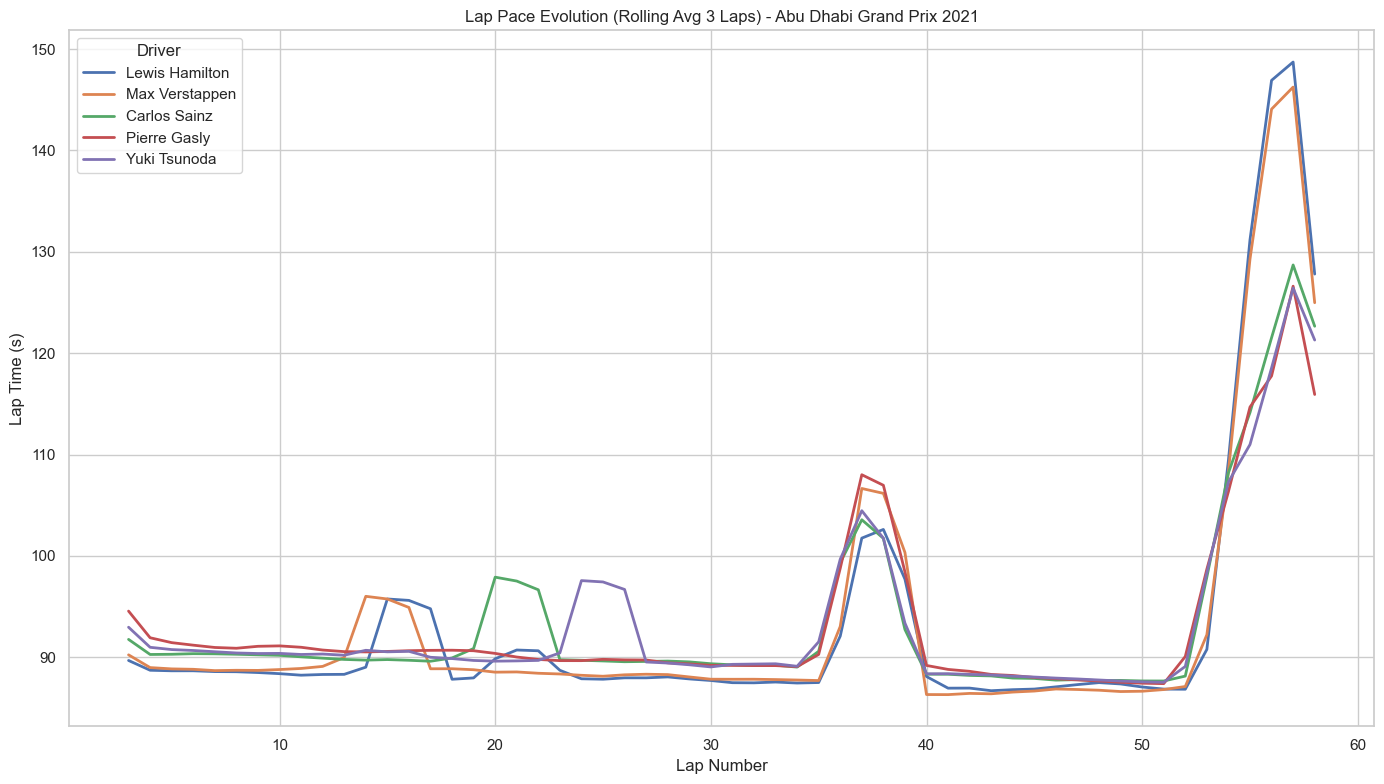

Saved lap_pace_trace_2021.png


In [6]:
analyze_lap_pace(laps, results)

## Analysis 2: Pit Stop Performance

### Why Pit Stops Matter:
In modern F1, races are often won or lost in the pits:
- **2-3 seconds** can make the difference between positions
- Consistent performance indicates team operational excellence
- Pit strategy (when to stop) is as important as speed

### Time Period: 2014-2020 Hybrid Era
We focus on this era because:
- More consistent regulations
- Similar pit equipment and tire suppliers
- Allows fair team comparison

### Analysis Approach:
1. **Merge** pit stop data with team information
2. **Filter** for top 10 teams by pit stop count (most active teams)
3. **Remove outliers** (>40s stops are usually repairs/penalties, not standard stops)
4. **Visualize** distribution using boxplots to show:
   - Median performance (middle line)
   - Consistency (box height)
   - Outliers (exceptional stops)

### What the Boxplot Shows:
- **Box**: 50% of pit stops fall within this range (IQR)
- **Line in box**: Median pit stop duration
- **Whiskers**: Full range of normal stops
- **Dots**: Outliers (unusually slow/fast stops)

**Lower boxes = Faster, more consistent pit crews**

In [7]:
def analyze_pit_strategy(pits, results):
    print("\n--- Analyzing Pit Stop Strategy ---")
    
    # Unique driver-race-constructor mapping
    driver_team_map = results[['raceId', 'driverId', 'constructor_name']].drop_duplicates()
    pits_merged = pd.merge(pits, driver_team_map, on=['raceId', 'driverId'], how='inner')
    
    # Filter for Hybrid Era 2014+
    if 'year' in pits_merged.columns:
        pits_modern = pits_merged[pits_merged['year'] >= 2014]
    else:
        print("WARNING: year column missing in pits, skipping filter.")
        pits_modern = pits_merged
    
    # Calculate Median Stop Duration by Team (Top 10 Teams by count)
    top_teams = pits_modern['constructor_name'].value_counts().head(10).index
    pits_top_teams = pits_modern[pits_modern['constructor_name'].isin(top_teams)]
    
    # Convert duration to seconds
    pits_top_teams['stop_seconds'] = pits_top_teams['milliseconds'] / 1000
    
    # Remove outliers (stops > 40s)
    pits_clean = pits_top_teams[pits_top_teams['stop_seconds'] < 40] 

    plt.figure(figsize=(12, 6))
    order = pits_clean.groupby('constructor_name')['stop_seconds'].median().sort_values().index
    sns.boxplot(data=pits_clean, x='constructor_name', y='stop_seconds', order=order, palette='Set3')
    plt.title("Team Pit Stop Performance (2014-2020) - Distribution")
    plt.xlabel("Constructor")
    plt.ylabel("Time (s)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/team_pit_performance.png")
    plt.show()
    print("Saved team_pit_performance.png")


--- Analyzing Pit Stop Strategy ---


/var/folders/8h/2y7xz9gx3xb4c1bvtgwl9xqh0000gn/T/ipykernel_74173/3998301011.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pits_top_teams['stop_seconds'] = pits_top_teams['milliseconds'] / 1000
/var/folders/8h/2y7xz9gx3xb4c1bvtgwl9xqh0000gn/T/ipykernel_74173/3998301011.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pits_clean, x='constructor_name', y='stop_seconds', order=order, palette='Set3')


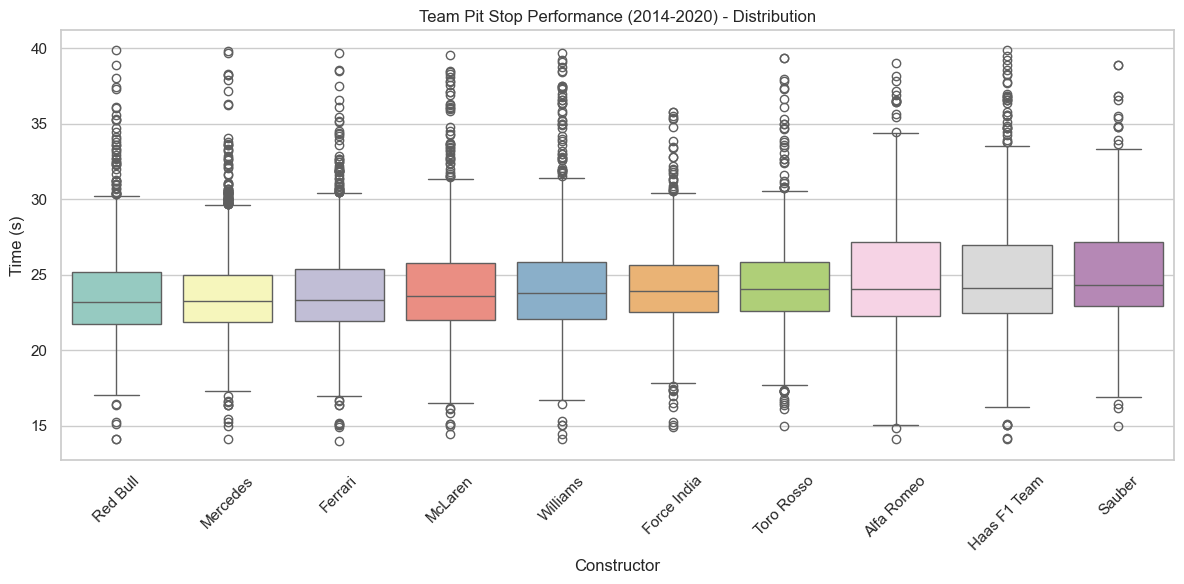

Saved team_pit_performance.png


In [8]:
analyze_pit_strategy(pits, results)

##  Analysis 3: Circuit Overtaking Potential

### The "Processional" vs "Action-Packed" Debate:
Not all circuits are equal for racing excitement:
- Some tracks (like Monaco) make overtaking nearly impossible
- Others (like Monza, Spa) have multiple overtaking zones
- This dramatically affects race strategy and entertainment value

### Our Metric: Position Change
We calculate "overtaking potential" using:
```
Overtaking Score = Average |Grid Position - Final Position|
```

### Why Absolute Value?
We care about **position changes** regardless of direction:
- Moving from P10 → P5 = exciting (5 positions gained)
- Moving from P5 → P10 = also dramatic (5 positions lost)
- Both indicate on-track action and strategic opportunities

### Methodology:
1. Calculate position change for every driver in every race
2. Take absolute value (we count all movement)
3. Average by circuit across all races held there
4. Filter for established circuits (10+ races for statistical significance)

### Strategic Implications:
- **High overtaking circuits**: Qualifying less critical, race pace matters more
- **Low overtaking circuits**: Qualifying is crucial, track position is king
- Teams adjust strategies accordingly (aggressive vs conservative)

In [9]:
def analyze_circuit_intelligence(results):
    print("\n--- Analyzing Circuit Intelligence (Overtaking) ---")
    
    # Calculate position gain
    results['position_gain'] = results['grid'] - results['positionOrder']
    
    # Exclude races where grid was 0
    valid_results = results[results['grid'] > 0]
    
    # Aggregate by Circuit
    circuit_stats = valid_results.groupby('race_name').agg(
        avg_gain=('position_gain', 'mean'),
        abs_gain=('position_gain', lambda x: x.abs().mean()),
        count=('raceId', 'nunique')
    ).reset_index()
    
    # Filter for active circuits (> 10 races held)
    circuit_stats = circuit_stats[circuit_stats['count'] >= 10]
    
    # Top 10 High "Action" Circuits
    top_action = circuit_stats.sort_values('abs_gain', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_action, x='abs_gain', y='race_name', palette='coolwarm')
    plt.title("Circuit Overtaking Potential (Avg Position Change)")
    plt.xlabel("Avg Position Change (Abs Value)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/circuit_overtaking_rank.png")
    plt.show()
    print("Saved circuit_overtaking_rank.png")


--- Analyzing Circuit Intelligence (Overtaking) ---


/var/folders/8h/2y7xz9gx3xb4c1bvtgwl9xqh0000gn/T/ipykernel_74173/1580057941.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_action, x='abs_gain', y='race_name', palette='coolwarm')


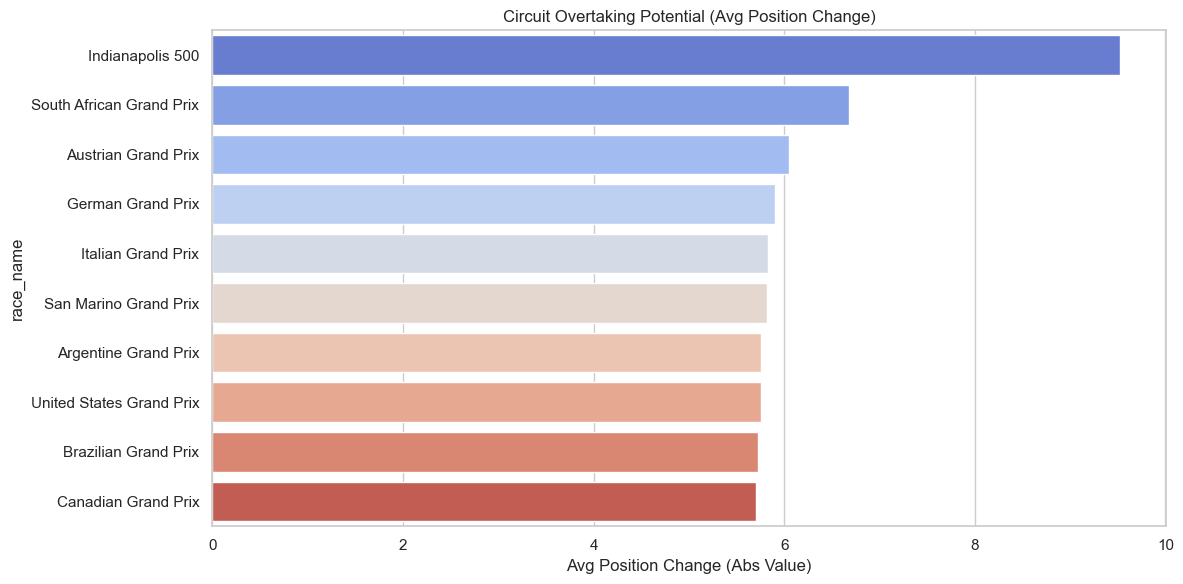

Saved circuit_overtaking_rank.png


In [10]:
analyze_circuit_intelligence(results)

## Analysis 4: Championship Battle Dynamics

### What Makes a Great Championship?
The drama of F1 often lies in season-long battles between drivers:
- Close points battles create tension
- Momentum swings after each race
- The final race often decides the champion

### Default: 2021 Season
We analyze 2021 by default because it featured one of the most dramatic championship battles in history:
- Hamilton vs Verstappen
- Went down to the final lap of the final race
- Multiple lead changes throughout the season

### Visualization: Cumulative Points
We plot **cumulative points** after each race for the top 2-3 contenders:
- X-axis: Race number (round)
- Y-axis: Total points accumulated
- Lines crossing = lead changes
- Gap widening/narrowing = momentum shifts

### How to Read the Chart:
- **Parallel lines**: Consistent gap, no momentum change
- **Lines converging**: Championship tightening
- **Lines diverging**: One driver pulling away
- **Crossing lines**: Lead changes hands

### Strategic Insight:
This analysis helps understand:
- When did momentum shift?
- Which races were pivotal?
- How close was the championship?
- Did consistency or peak performance win?

In [11]:
def analyze_championship_battle(results, year=2021):
    print(f"\n--- Analyzing Championship Battle ({year}) ---")
    
    season = results[results['year'] == year].copy()
    if season.empty:
        print(f"Year {year} not found. Skipping.")
        return
        
    # Get top 2 drivers by total points
    top_drivers = season.groupby('driverId')['points'].sum().sort_values(ascending=False).head(2).index
    battle = season[season['driverId'].isin(top_drivers)].copy()
    
    # Sort by round
    battle = battle.sort_values(['round'])
    
    # Calculate Cumulative Points
    battle['cumulative_points'] = battle.groupby('driverId')['points'].cumsum()
    
    # Check for driver_name
    if 'driver_name' not in battle.columns:
        print("Adding driver_name for championship battle...")
        driver_map = results[['driverId', 'driver_name']].drop_duplicates()
        battle = pd.merge(battle, driver_map, on='driverId', how='left')
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=battle, x='round', y='cumulative_points', hue='driver_name', marker='o', linewidth=2.5)
    plt.title(f"Championship Battle {year}: Points Progression")
    plt.xlabel("Race Round")
    plt.ylabel("Cumulative Points")
    plt.legend(title='Driver')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/championship_battle_{year}.png")
    plt.show()
    print(f"Saved championship_battle_{year}.png")


--- Analyzing Championship Battle (2021) ---


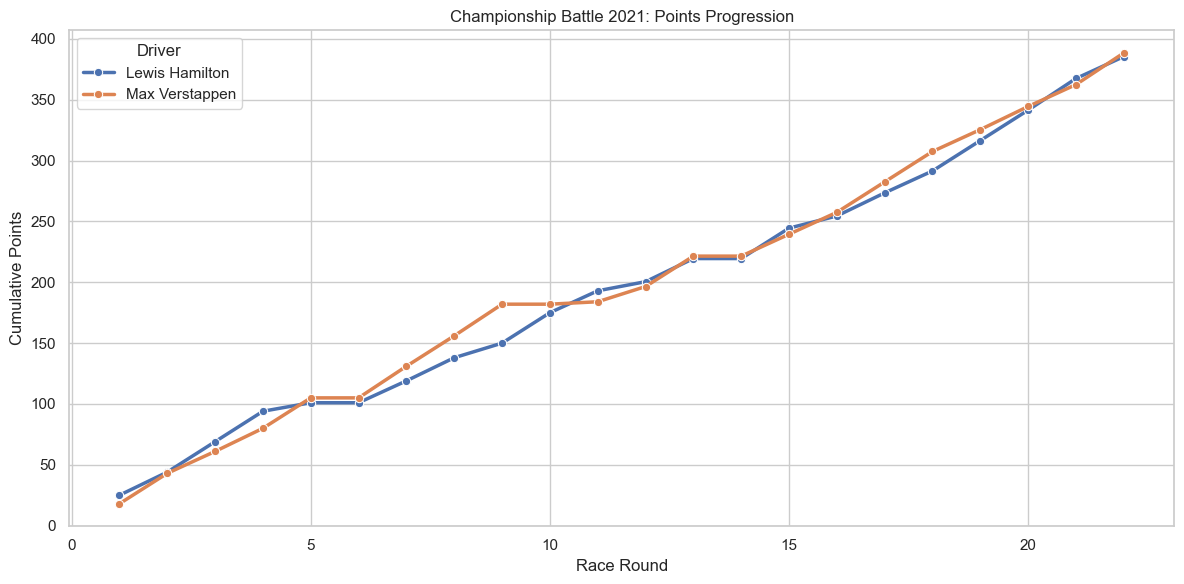

Saved championship_battle_2021.png


In [12]:
analyze_championship_battle(results, year=2021)

## Generate Strategy Report

In [13]:
def generate_report(results):
    print("\n--- Generating Strategy Report ---")
    report = """# F1 Strategy & Championship Intelligence Report

## Overview
This report analyzes advanced race dynamics, including lap pace evolution, pit crew performance, and circuit characteristics.

## 1. Pit Stop Performance (Hybrid Era 2014-2020)
Analysis of pit stop durations reveals the operational efficiency of teams.
![Team Pit Performance](../images/team_pit_performance.png)

## 2. Circuit Intelligence
Top circuits ranked by average position changes (overtaking potential). High variance tracks offer more strategic opportunities.
![Circuit Overtaking](../images/circuit_overtaking_rank.png)

## 3. Championship Dynamics (Case Study: 2021)
The visible tightening of the points gap between contenders throughout the season.
![Championship Battle](../images/championship_battle_2021.png)

## 4. Lap Pace Analysis
Rolling average lap times for the selected race showcase tire degradation and stint pace.
![Lap Pace](../images/lap_pace_trace_2021.png)
"""
    with open("../reports/strategy_intelligence_report.md", "w") as f:
        f.write(report)
    print("Report generated: ../reports/strategy_intelligence_report.md")

In [14]:
generate_report(results)


--- Generating Strategy Report ---
Report generated: ../reports/strategy_intelligence_report.md


## Summary & Next Steps

### What We Analyzed:
 **Lap pace evolution** - tire degradation and race management  
 **Pit stop performance** - team operational excellence  
 **Circuit overtaking potential** - track characteristics  
 **Championship battles** - season-long drama  

### Key Outputs:
- **4 Visualizations** saved to `images/` folder:
  - Lap pace trace (2021)
  - Team pit stop performance comparison
  - Circuit overtaking rankings
  - Championship points progression
- **Strategy Report** saved to `../reports/strategy_intelligence_report.md`

### Strategic Insights Gained:

#### 1. **Race Strategy**
- Tire management patterns visible in lap pace
- Pit stop timing impact on race outcomes
- Rolling average smooths out anomalies

#### 2. **Team Operations**
- Red Bull, Mercedes, and Williams historically strong pit crews
- Consistency matters as much as speed
- 2-3 second difference can determine race results

#### 3. **Circuit Characteristics**
- Some tracks favor overtaking (Monza, Spa)
- Others are "processional" (Monaco, Hungary)
- Strategic implications for qualifying vs race pace

#### 4. **Championship Drama**
- 2021 was one of the closest battles in history
- Multiple lead changes create excitement
- Consistency vs peak performance trade-offs

### Further Analysis Ideas:
- Compare different tire strategies
- Analyze safety car impact on races
- Study weather effects on lap times
- Investigate qualifying vs race pace correlation
- Deep-dive into specific iconic races